In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import dask
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [5]:
def get_mse_bias(prediction, target):
    diff = prediction - target
    dims = ["tile", "x", "y", "z"]
    dims = set(diff.dims) & set(dims)
    bias = vcm.weighted_average(diff, grid.area, dims=dims)
    mse = vcm.weighted_average(diff ** 2, grid.area, dims=dims)
    return mse, bias


def _get_pred_targ_keys(varname):
    base = "tendency_of_{varname}_due_to_zhao_carr_{source}"
    pr_base = "surface_precipitation_due_to_zhao_carr_{}"

    if "precipitation" in varname:
        return pr_base.format("emulator"), pr_base.format("physics")
    else:
        return (
            base.format(varname=varname, source="emulator"),
            base.format(varname=varname, source="physics")
        )

def _get_field_metrics(pred_ds, targ_ds, fields, key_func):

    ds = xr.Dataset()
    for f in fields:
        p_key, t_key = key_func(f)
        mse, bias = get_mse_bias(pred_ds[p_key], targ_ds[t_key])
        ds[f"mse.{f}"] = mse
        ds[f"bias.{f}"] = bias

    return ds

def get_all_vars_metrics(pred_ds, targ_ds):
    fields = ["air_temperature", "specific_humidity", "cloud_water", "surface_precipitation"]

    return _get_field_metrics(pred_ds, targ_ds, fields, _get_pred_targ_keys)


BIAS_FIELDS = [
        "air_temperature",
        "specific_humidity",
        "cloud_water_mixing_ratio",
        "total_precipitation",
        "h500",
        "USWRFtoa",
        "ULWRFtoa",
        "PWAT",
        "pressure_thickness_of_atmospheric_layer"
    ]

def get_all_baseline_metrics(online_ds, offline_ds):

    fields = BIAS_FIELDS

    return _get_field_metrics(online_ds, offline_ds, fields, lambda x: (x, x))

In [6]:
base_prefix = "zc-emu-monthly-normfix-m{init}-seed3-30d-v1"

In [7]:
def _open_group_pairs(prefix):

    online = common.open_group(f"{prefix}-online")
    offline = common.open_group(f"{prefix}-offline")

    return online, offline

groups = [base_prefix.format(init=f"{i:02d}") for i in range(1, 13)]
jobs = [delayed(_open_group_pairs)(g) for g in groups]
opened = Parallel(n_jobs=12)(jobs)

In [8]:
prefix_opened_map = {prefix: handles for prefix, handles in zip(groups, opened)}

In [9]:
client = dask.distributed.Client()

In [10]:
@common.memoize_xarray_out
def get_group_mse_bias_metrics(group):

    online, offline = prefix_opened_map[group]

    ds = xr.Dataset()
    online_metr = get_all_vars_metrics(online, online)
    for k, v in online_metr.items():
        ds[f"online.{k}"] = v
    
    diag_metr = get_all_vars_metrics(online, offline)
    for k, v in diag_metr.items():
        if "mse" not in k:
            ds[f"diagnostic.{k}"] = v

    offline_metr = get_all_vars_metrics(offline, offline)
    for k, v in offline_metr.items():
        ds[f"offline.{k}"] = v

    return ds.load()


In [11]:
results = [
    get_group_mse_bias_metrics(base_prefix.format(init=f"{i:02d}")) 
    for i in range(1, 13)
]

In [12]:
to_concat = [ds.drop_vars("time") for ds in results]

In [13]:
ds = xr.concat(to_concat, dim="init")

In [14]:
dt = 900 # s
seconds_per_day = 60 * 60 * 24  # seconds/min * min/hr * hr/day
m_to_mm = 1000

# from physcons.f
cp = 1.0046e3 # J / (kg K)
gravity = 9.80665 # m / s^2|
lv = 2.5e6  # J / kg water
rho_water = 1000.0 # kg / m^3

def kg_m2_s_to_mm_day(da):
    return da * seconds_per_day / rho_water * m_to_mm

In [15]:
scale_factors = {
    "air_temperature": seconds_per_day, # seconds per day
    "specific_humidity": seconds_per_day * 1000,
    "cloud_water": seconds_per_day * 1000,
    "surface_precipitation": seconds_per_day / rho_water * m_to_mm,
}

units = {
    "air_temperature": "K/day", # seconds per day,
    "specific_humidity": "g/kg/day",
    "cloud_water": "g/kg/day",
    "surface_precipitation": "mm/day",
}

In [14]:
def plot_var_stats(ds, field):
    for_table = xr.Dataset()
    fig, ax = plt.subplots(1, 2, dpi=120, figsize=(8,4), constrained_layout=True)
    for k, v in ds.items():
        run, metric, f = k.split(".")
        da = ds[k]
        if field == f:
            if metric == "mse":
                da = np.sqrt(da)
                metric = "rmse"
                k = k.replace("mse", "rmse")
                da = da * scale_factors.get(field, 1)
                da.mean(dim="init").plot(label=f"{run}", ax=ax[0])
                ax[0].set_title(f"{field} {metric}")
                ax[0].set_ylabel(units[field])
                ax[0].legend()
            if metric == "bias":
                da = da * scale_factors.get(field, 1)
                da.mean(dim="init").plot(label=f"{run}", ax=ax[1])
                ax[1].set_title(f"{field} {metric}")
                ax[1].set_ylabel(units[field])
                ax[1].legend()
            da.attrs["units"] = units[field]
            for_table[k] = da
    plt.legend()
    plt.show()
    return for_table

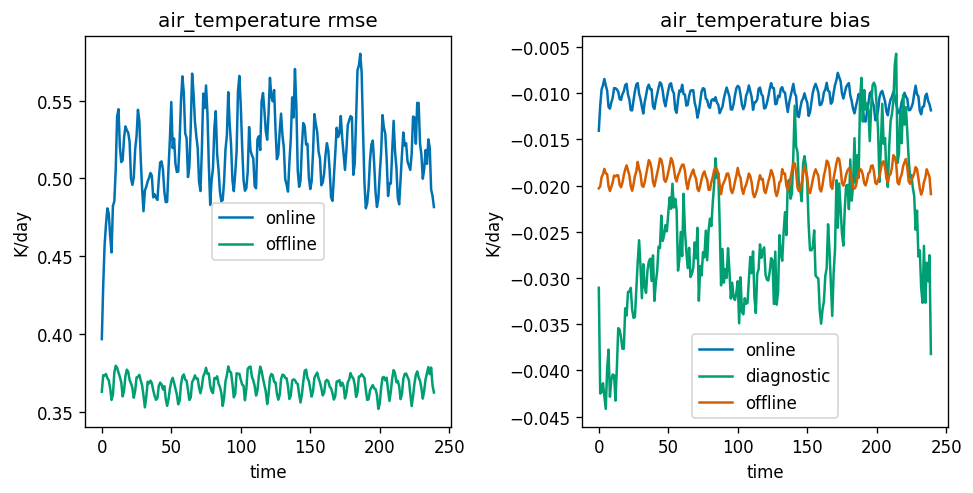

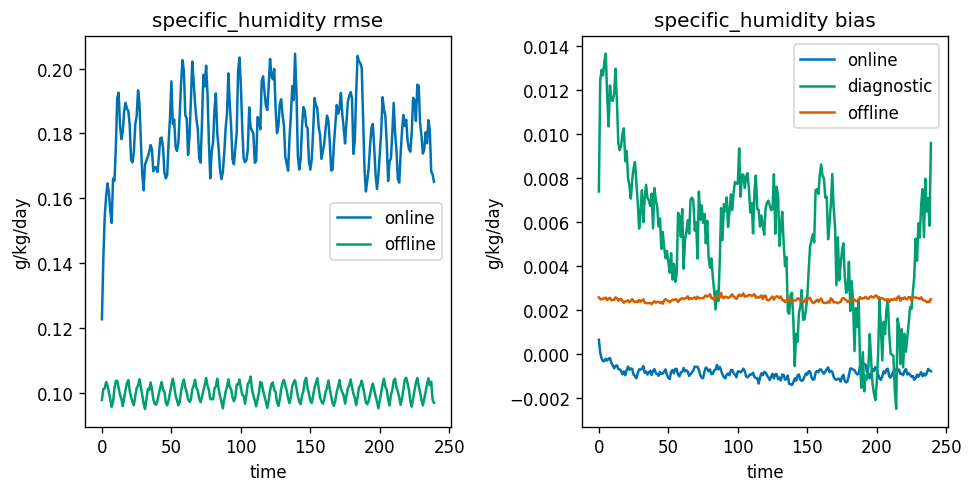

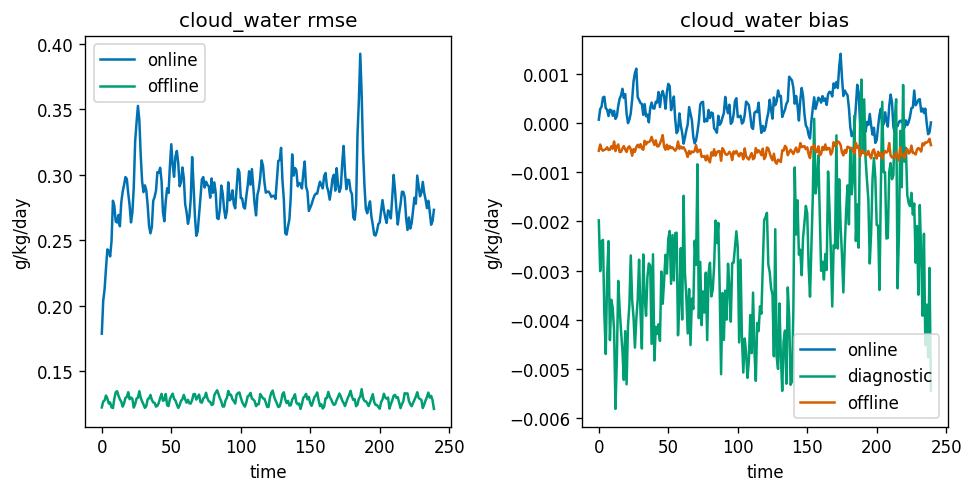

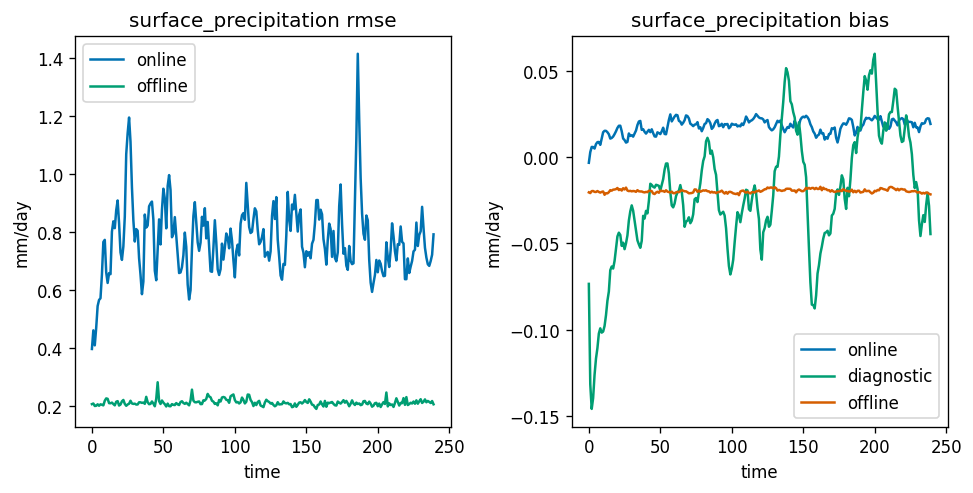

In [15]:

fields = ["air_temperature", "specific_humidity", "cloud_water", "surface_precipitation"]
metrics = xr.Dataset()
for field in fields:
    metrics = metrics.merge(plot_var_stats(ds, field))

In [15]:
metric_pd = metrics.mean().to_pandas()

In [16]:
items = []
for idx, val in metric_pd.iteritems():
    run, metr, field = idx.split(".")
    items.append((field, run, metr, val))
new_df = pd.DataFrame(items, columns=["field", "run_type", "metric_name", "value"])



In [74]:
new_df.pivot(index=["run_type", "metric_name"], columns="field", values="value")

field                   air_temperature  cloud_water  specific_humidity  \
run_type   metric_name                                                    
diagnostic bias               -0.025601    -0.002871           0.005149   
offline    bias               -0.019096    -0.000564           0.002485   
           rmse                0.367649     0.127980           0.100102   
online     bias               -0.010531     0.000246          -0.000859   
           rmse                0.515778     0.284725           0.180276   

field                   surface_precipitation  
run_type   metric_name                         
diagnostic bias                     -0.022310  
offline    bias                     -0.019664  
           rmse                      0.211918  
online     bias                      0.017589  
           rmse                      0.773997

In [75]:
new_df.pivot(index=["run_type", "metric_name"], columns="field", values="value").to_csv("bias_rmse.csv")

In [16]:
@common.memoize_xarray_out
def get_group_baseline_metrics(group):

    online, offline = prefix_opened_map[group]

    ds = get_all_baseline_metrics(online, offline)

    return ds.load()   

In [17]:
results = [
    get_group_baseline_metrics(base_prefix.format(init=f"{i:02d}")) 
    for i in range(1, 13)
]

In [18]:
to_concat = [ds.drop_vars("time") for ds in results]
baseline_ds = xr.concat(to_concat, dim="init")

In [19]:
def limit_sigfigs(df, num_sigfigs=3):
    power_offset = -np.floor(np.log10(np.abs(df))).astype(int)
    to_round = df * 10.0 ** power_offset
    return to_round.round(num_sigfigs - 1) * 10.0 ** -power_offset

In [20]:
baseline_df = baseline_ds.mean().to_pandas()
items = []
for idx, val in baseline_df.iteritems():
    metr, field = idx.split(".")
    if metr == "bias":
        items.append((field, val))
baseline_df = pd.DataFrame(items, columns=["field", "value"]).set_index("field")["value"]
baseline_df["net_outgoing"] = baseline_df["USWRFtoa"] + baseline_df["ULWRFtoa"]
baseline_df

field
air_temperature            -9.467291e-02
specific_humidity          -1.252163e-06
cloud_water_mixing_ratio    1.526239e-07
total_precipitation         3.153312e-07
h500                       -1.887780e+00
USWRFtoa                    1.337382e+00
ULWRFtoa                   -1.398786e+00
PWAT                       -6.689321e-03
net_outgoing               -6.140423e-02
Name: value, dtype: float64

In [15]:
ab = baseline_ds["bias.air_temperature"].stack({"sample": ["init", "time"]})

ab_hat = []
for i in range(10_000):
    hat = np.random.choice(ab.values, size=2880, replace=True).mean(axis=0)
    ab_hat.append(hat)

lower = np.percentile(ab_hat, 2.5, axis=0)
upper = np.percentile(ab_hat, 97.5, axis=0)

In [21]:
@common.memoize_xarray_out
def get_global_avg_v6(group, field, use_online):
    
    online, offline = prefix_opened_map[group]

    if use_online:
        ds = online
    else:
        ds = offline

    return vcm.weighted_average(ds[field], grid.area).load().to_dataset()
    


In [22]:
def get_glob_avgs(prefix):

    offline = []
    online = []
    for i in range(1, 13):
        group = prefix.format(init=f"{i:02d}")
        ds = xr.Dataset({f: get_global_avg_v6(group, f, False)[f] for f in BIAS_FIELDS})
        offline.append(ds.drop_vars("time"))
        ds = xr.Dataset({f: get_global_avg_v6(group, f, True)[f] for f in BIAS_FIELDS})
        online.append(ds.drop_vars("time"))

    offline = xr.concat(offline, dim="init")
    online = xr.concat(online, dim="init")

    return offline, online

In [23]:
baseline_avgs, online_avgs = get_glob_avgs(base_prefix)

In [24]:
baseline_avgs["net_outgoing"] = baseline_avgs["USWRFtoa"] + baseline_avgs["ULWRFtoa"]
online_avgs["net_outgoing"] = online_avgs["USWRFtoa"] + online_avgs["ULWRFtoa"]


Mass weighting air_temperature


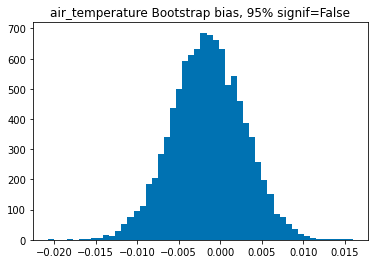

Mass weighting specific_humidity


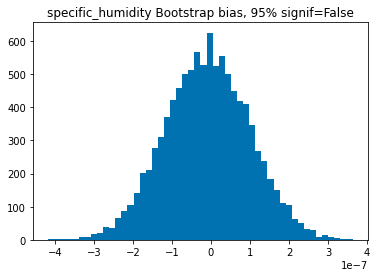

Mass weighting cloud_water_mixing_ratio


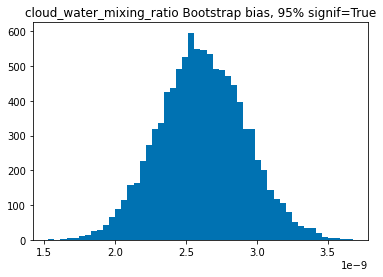

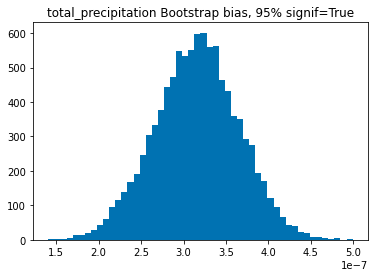

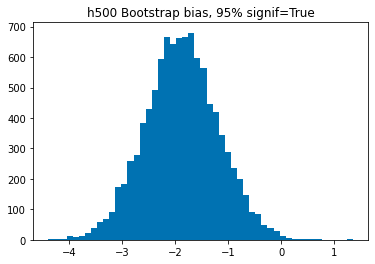

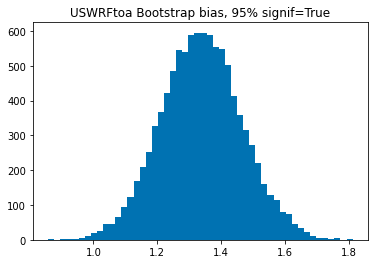

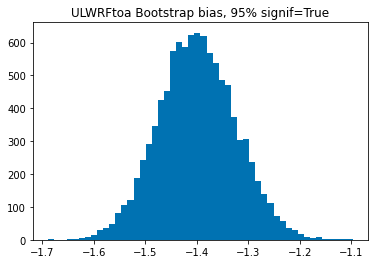

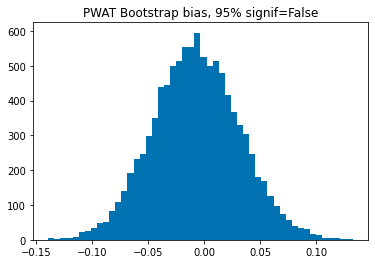

Mass weighting pressure_thickness_of_atmospheric_layer


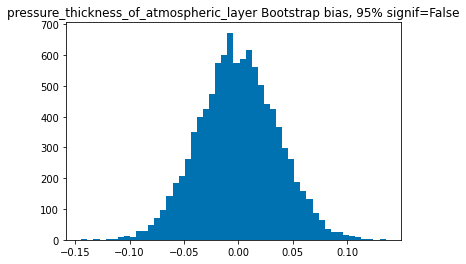

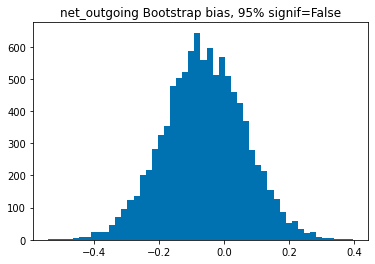

In [26]:
off_wgt = baseline_avgs.pressure_thickness_of_atmospheric_layer / baseline_avgs.pressure_thickness_of_atmospheric_layer.sum(dim="z")
on_wgt = online_avgs.pressure_thickness_of_atmospheric_layer / online_avgs.pressure_thickness_of_atmospheric_layer.sum(dim="z")
signifs = []
for k, da in online_avgs.items():
    if "z" in da.dims:
        print(f"Mass weighting {k}")
        off_values = (baseline_avgs[k]*off_wgt).values.flatten()
        on_values = (da*on_wgt).values.flatten()
    else:
        off_values = baseline_avgs[k].values.flatten()
        on_values = da.values.flatten()
        
    bias, signif = common.bootstrap_bias_signif(off_values, on_values)
    signifs.append(signif)
    plt.hist(bias, bins=50)
    plt.title(f"{k} Bootstrap bias, 95% signif={signif}")
    plt.show()


In [27]:
(online_avgs - baseline_avgs).mean()

<xarray.Dataset>
Dimensions:                                  ()
Data variables:
    air_temperature                          float64 -0.09467
    specific_humidity                        float64 -1.252e-06
    cloud_water_mixing_ratio                 float64 1.526e-07
    total_precipitation                      float64 3.153e-07
    h500                                     float32 -1.888
    USWRFtoa                                 float32 1.337
    ULWRFtoa                                 float32 -1.399
    PWAT                                     float32 -0.006689
    pressure_thickness_of_atmospheric_layer  float64 -0.0008304
    net_outgoing                             float32 -0.0614

In [28]:
baseline_avgs

<xarray.Dataset>
Dimensions:                                  (z: 79, init: 12, time: 240)
Coordinates:
  * z                                        (z) float64 4.514 8.301 ... 998.3
Dimensions without coordinates: init, time
Data variables:
    air_temperature                          (init, time, z) float64 249.2 .....
    specific_humidity                        (init, time, z) float64 7.08e-06...
    cloud_water_mixing_ratio                 (init, time, z) float64 1.007e-2...
    total_precipitation                      (init, time) float64 2.963e-05 ....
    h500                                     (init, time) float32 5.631e+03 ....
    USWRFtoa                                 (init, time) float32 95.49 ... 9...
    ULWRFtoa                                 (init, time) float32 232.7 ... 2...
    PWAT                                     (init, time) float32 25.08 ... 2...
    pressure_thickness_of_atmospheric_layer  (init, time, z) float64 346.7 .....
    net_outgoing                             (init, time) float32 328.1 ... 3...

In [29]:
baseline_series = baseline_avgs.weighted(baseline_avgs.pressure_thickness_of_atmospheric_layer).mean().to_pandas()
baseline_series

air_temperature                             251.312464
specific_humidity                             0.002591
cloud_water_mixing_ratio                      0.000010
total_precipitation                           0.000032
h500                                       5660.707389
USWRFtoa                                     91.946347
ULWRFtoa                                    236.877356
PWAT                                         26.308177
pressure_thickness_of_atmospheric_layer    1455.318456
net_outgoing                                328.823703
dtype: float64

In [30]:
baseline_bias = (baseline_avgs - online_avgs).weighted(baseline_avgs.pressure_thickness_of_atmospheric_layer).mean().to_pandas()
bias_pct = (baseline_bias / baseline_series * 100).round(2)
bias_pct

air_temperature                            0.05
specific_humidity                          0.03
cloud_water_mixing_ratio                  -2.15
total_precipitation                       -1.00
h500                                       0.03
USWRFtoa                                  -1.45
ULWRFtoa                                   0.59
PWAT                                       0.03
pressure_thickness_of_atmospheric_layer    0.00
net_outgoing                               0.02
dtype: float64

In [31]:
out_df = pd.DataFrame()
out_df["Baseline avg."] = baseline_series
out_df["Online bias"] = baseline_bias
out_df["Pct change"] = bias_pct
out_df

,Baseline avg.,Online bias,Pct change
air_temperature,251.312464,1.141967e-01,0.05
specific_humidity,0.002591,7.287458e-07,0.03
cloud_water_mixing_ratio,0.000010,-2.063605e-07,-2.15
total_precipitation,0.000032,-3.153303e-07,-1.00
h500,5660.707389,1.887780e+00,0.03
USWRFtoa,91.946347,-1.337400e+00,-1.45
ULWRFtoa,236.877356,1.398802e+00,0.59
PWAT,26.308177,6.687326e-03,0.03
pressure_thickness_of_atmospheric_layer,1455.318456,1.075278e-03,0.00
net_outgoing,328.823703,6.140166e-02,0.02


In [32]:
out_df.to_csv("state_bias.csv")

In [33]:
names = {
    "air_temperature": "Air temperature [K]",
    "specific_humidity": "Specific humidity [g/kg]",
    "cloud_water_mixing_ratio": "Cloud water [g/kg]",
    "PWAT": "Precipitable water [kg/m$^2$]",
    "total_precipitation": "Surface precipitation [mm/day]",
    "USWRFtoa": "Upward shortwave at TOA [W/m$^2$]",
    "ULWRFtoa": "Upward longwave at TOA [W/m$^2$]",
    "net_outgoing": "Total outgoing radiation at TOA [W/m$^2$]",
    "h500": "500 hPa height [m]",
}

scale_functions = {
    "specific_humidity": lambda x: x * 1000,
    "cloud_water_mixing_ratio": lambda x: x * 1000,
    "total_precipitation": common.m_to_mm_day,
}

bias_values = []
new_names = []
baseline_mean = []
pct_change = []
for key, new_name in names.items():
    scale_func = scale_functions.get(key, lambda x: x)
    bias_values.append(scale_func(baseline_df[key]))
    baseline_mean.append(scale_func(baseline_series[key]))
    pct_change.append(bias_pct[key])
for_table = pd.DataFrame({"bias": bias_values, "baseline mean": baseline_mean, "pct_change": pct_change}, index=names.values())
for_table["bias"] = limit_sigfigs(for_table["bias"])
for_table["baseline mean"] = limit_sigfigs(for_table["baseline mean"])
for_table

,bias,baseline mean,pct_change
Air temperature [K],-0.094700,251.0000,0.05
Specific humidity [g/kg],-0.001250,2.5900,0.03
Cloud water [g/kg],0.000153,0.0096,-2.15
Precipitable water [kg/m$^2$],-0.006690,26.3000,0.03
Surface precipitation [mm/day],0.030300,3.0400,-1.00
Upward shortwave at TOA [W/m$^2$],1.340000,91.9000,-1.45
Upward longwave at TOA [W/m$^2$],-1.400000,237.0000,0.59
Total outgoing radiation at TOA [W/m$^2$],-0.061400,329.0000,0.02
500 hPa height [m],-1.890000,5660.0000,0.03


In [34]:
print(for_table.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &      bias &  baseline mean &  pct\_change \\
\midrule
Air temperature [K]                       & -0.094700 &       251.0000 &        0.05 \\
Specific humidity [g/kg]                  & -0.001250 &         2.5900 &        0.03 \\
Cloud water [g/kg]                        &  0.000153 &         0.0096 &       -2.15 \\
Precipitable water [kg/m\$\textasciicircum 2\$]             & -0.006690 &        26.3000 &        0.03 \\
Surface precipitation [mm/day]            &  0.030300 &         3.0400 &       -1.00 \\
Upward shortwave at TOA [W/m\$\textasciicircum 2\$]         &  1.340000 &        91.9000 &       -1.45 \\
Upward longwave at TOA [W/m\$\textasciicircum 2\$]          & -1.400000 &       237.0000 &        0.59 \\
Total outgoing radiation at TOA [W/m\$\textasciicircum 2\$] & -0.061400 &       329.0000 &        0.02 \\
500 hPa height [m]                        & -1.890000 &      5660.0000 &        0.03 \\
\bottomrule
\end{tabular}



In [ ]:
\begin{tabular}{lrr}
\toprule
{} &      bias &  pct\_change \\
\midrule
Air temperature [K]                       & -0.094700 &       -0.04 \\
Specific humidity [g/kg]                  & -0.001250 &       -0.05 \\
Cloud water [g/kg]                        &  0.000153 &        2.01 \\
Precipitable water [kg/m\$\textasciicircum 2\$]             & -0.006690 &       -0.03 \\
Surface precipitation [mm/day]            &  0.030300 &        1.00 \\
Upward shortwave at TOA [W/m\$\textasciicircum 2\$]         &  1.340000 &        1.45 \\
Upward longwave at TOA [W/m\$\textasciicircum 2\$]          & -1.400000 &       -0.59 \\
Total outgoing radiation at TOA [W/m\$\textasciicircum 2\$] & -0.061400 &       -0.02 \\
500 hPa height [m]                        & -1.890000 &       -0.03 \\
\bottomrule
\end{tabular}

